In [54]:
library(ggplot2); packageVersion("ggplot2")
library(tidyr)
library(tibble)
library(dplyr)
library(vegan); packageVersion("vegan")
library(scales)
library(repr)
library(viridis)
library(pheatmap)

[1] ‘3.2.1’

[1] ‘2.5.6’

In [246]:
sample_name = 'AWTP_2_RO2_bulk_5'
contig_data_file = '~/data/awtp2_metagenomics/contigs_dbs/KNLK_23_contigs_basic_info.txt'
cov_means_file = '~/data/awtp2_metagenomics/metagenome_info_tables/cov_tables/KNLK_23_mean_coverage_Q2Q3_contigs.txt'
cov_std_file = '~/data/awtp2_metagenomics/metagenome_info_tables/cov_tables/KNLK_23_std_coverage_contigs.txt'

In [247]:
# anvi-export-table --table contigs_basic_info KNLK_23_contigs.db -o KNLK_23_contigs_basic_info.txt
contig_data <- read.table(contig_data_file, sep='\t', header=TRUE) # add length and GC info
contig_data <- contig_data[c('contig', 'length', 'gc_content')]

In [248]:
# import coverage table
cov_means <- read.table(cov_means_file, header=TRUE)
cov_means <- subset(cov_means, select = -c(contig)) #first col is actually the split so remove it since we want contigs (luckily values for all splits in a contig are identical since we specified contig)
names(cov_means)[names(cov_means) == "X__parent__"] <- "contig"
cov_means <- unique(cov_means)
row.names(cov_means) <- cov_means$contig
cov_means <- subset(cov_means, select = -c(contig))
#change sample column name to "sample" so this can be applied to all tables
names(cov_means)[names(cov_means) == sample_name] <- "sample"

In [249]:
# calculate relative coverage
cov_means.norm <- apply(cov_means, 2, function(x) x/sum(x))

# get maximum value of control normalized cov as a column
max_cont.mean <- apply(cov_means.norm, 1, function(x) max(x[2:7]))
cov_means.norm <- cbind(cov_means.norm, max_cont.mean)
cov_means.norm <- as.data.frame(cov_means.norm)

In [250]:
# import std cov table
cov_stds <- read.table(cov_stds_file, header=TRUE)
cov_stds <- subset(cov_stds, select = -c(contig)) #first col is actually the split so remove it since we want contigs (luckily values for all splits in a contig are identical since we specified contig)
names(cov_stds)[names(cov_stds) == "X__parent__"] <- "contig"
cov_stds <- unique(cov_stds)
row.names(cov_stds) <- cov_stds$contig
cov_stds <- subset(cov_stds, select = -c(contig))
names(cov_stds)[names(cov_stds) == sample_name] <- "sample"

In [251]:
# normalize the stdev of coverage for each scaffold by the mean cov for that scaffold (coefficient of variation)
cov_stds.norm <- cov_stds/cov_means

# remove NA and inf values
cov_stds.norm[is.na(cov_stds.norm)] <- 0
cov_stds.norm[cov_stds.norm==Inf] <- 0

# get maximum value of normalized stdev cov as a column
max_cont.std <- apply(cov_stds.norm, 1, function(x) max(x[2:7]))
cov_stds.norm <- cbind(cov_stds.norm, max_cont.std)
cov_stds.norm <- as.data.frame(cov_stds.norm)

In [252]:
df <- merge(cov_means.norm, cov_stds.norm, by=0, suffixes = c('.mean', '.std'))
df <- merge(contig_data, df, by.y='Row.names', by.x='contig')
row.names(df) <- df$contig
df <- subset(df, select = -c(contig))
head(df)

,length,gc_content,sample.mean,neg_ex_1.mean,neg_field_1.mean,neg_field_2.mean,neg_field_bf.mean,pos_ex_1.mean,pos_ex_2.mean,max_cont.mean,sample.std,neg_ex_1.std,neg_field_1.std,neg_field_2.std,neg_field_bf.std,pos_ex_1.std,pos_ex_2.std,max_cont.std
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
KNLK_23_100013,2652,0.6338612,1.325904e-04,0,0,0,0,0,0,0,0.2340898,0,0,0,0,0,0,0
KNLK_23_100015,1327,0.6518463,5.981206e-06,0,0,0,0,0,0,0,0.3895175,0,0,0,0,0,0,0
KNLK_23_100020,1214,0.4991763,6.257953e-06,0,0,0,0,0,0,0,0.3475952,0,0,0,0,0,0,0
KNLK_23_100024,2046,0.6999022,6.929976e-06,0,0,0,0,0,0,0,0.3965197,0,0,0,0,0,0,0
KNLK_23_100031,1437,0.3681280,9.520172e-06,0,0,0,0,0,0,0,0.5325306,0,0,0,0,0,0,0
KNLK_23_100046,1123,0.5939448,6.185838e-06,0,0,0,0,0,0,0,0.4462138,0,0,0,0,0,0,0


In [253]:
contam_rule <- ((df$max_cont.mean > df$sample.mean) & (df$max_cont.std < df$sample.std)) | (df$sample.mean == 0)
noncontam_rule <- ((df$max_cont.mean < df$sample.mean) & (df$max_cont.std > df$sample.std)) | (df$max_cont.mean == 0)
df$iscontam <- ifelse(contam_rule, 'contam', ifelse(noncontam_rule, 'non_contam', 'unknown')) #nested if else to cover contam, noncontam, and unknown

In [254]:
head(df[df$iscontam=='unknown',])
# ways to fail:
# mean cov s > mean cov c AND mean std s > mean std c
# mean cov s < mean cov c AND mean std s < mean std c

,length,gc_content,sample.mean,neg_ex_1.mean,neg_field_1.mean,neg_field_2.mean,neg_field_bf.mean,pos_ex_1.mean,pos_ex_2.mean,max_cont.mean,sample.std,neg_ex_1.std,neg_field_1.std,neg_field_2.std,neg_field_bf.std,pos_ex_1.std,pos_ex_2.std,max_cont.std,iscontam
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
KNLK_23_100271,1127,0.6770186,1.497464e-05,5.088015e-08,5.400810e-06,1.891729e-05,2.941038e-06,3.429599e-07,0.0000000000,1.891729e-05,0.4983754,22.50435,0.6743893,1.7032605,3.3812647,2.6045170,0.000000,22.504352,unknown
KNLK_23_100345,1264,0.6250000,4.625003e-06,0.000000e+00,0.000000e+00,5.121613e-05,0.000000e+00,0.000000e+00,0.0000000000,5.121613e-05,0.3057321,0.00000,0.0000000,1.3403379,0.0000000,0.0000000,0.000000,1.340338,unknown
KNLK_23_100381,1023,0.2991202,4.796299e-06,0.000000e+00,1.300787e-05,1.634456e-04,7.902513e-05,0.000000e+00,0.0000000000,1.634456e-04,0.5701710,0.00000,1.1421966,0.2560948,0.3250622,0.0000000,0.000000,1.142197,unknown
KNLK_23_100438,2228,0.6916517,1.024365e-05,0.000000e+00,1.207046e-05,0.000000e+00,1.000014e-05,0.000000e+00,0.0000000000,1.207046e-05,0.5748678,0.00000,0.9965588,0.0000000,1.7332594,0.0000000,0.000000,1.733259,unknown
KNLK_23_100712,1719,0.3083188,5.493421e-06,0.000000e+00,1.553829e-06,1.678477e-04,8.964182e-05,0.000000e+00,0.0000000000,1.678477e-04,0.4458887,0.00000,2.6186560,0.2545970,0.2382859,0.0000000,0.000000,2.618656,unknown
KNLK_23_100815,1416,0.6666667,6.504182e-06,0.000000e+00,1.496136e-06,0.000000e+00,3.956337e-07,2.458980e-05,0.0007841643,7.841643e-04,0.4032429,0.00000,2.8658970,0.0000000,10.3856308,0.8108013,0.471119,10.385631,unknown


Warning message:
“Transformation introduced infinite values in continuous y-axis”

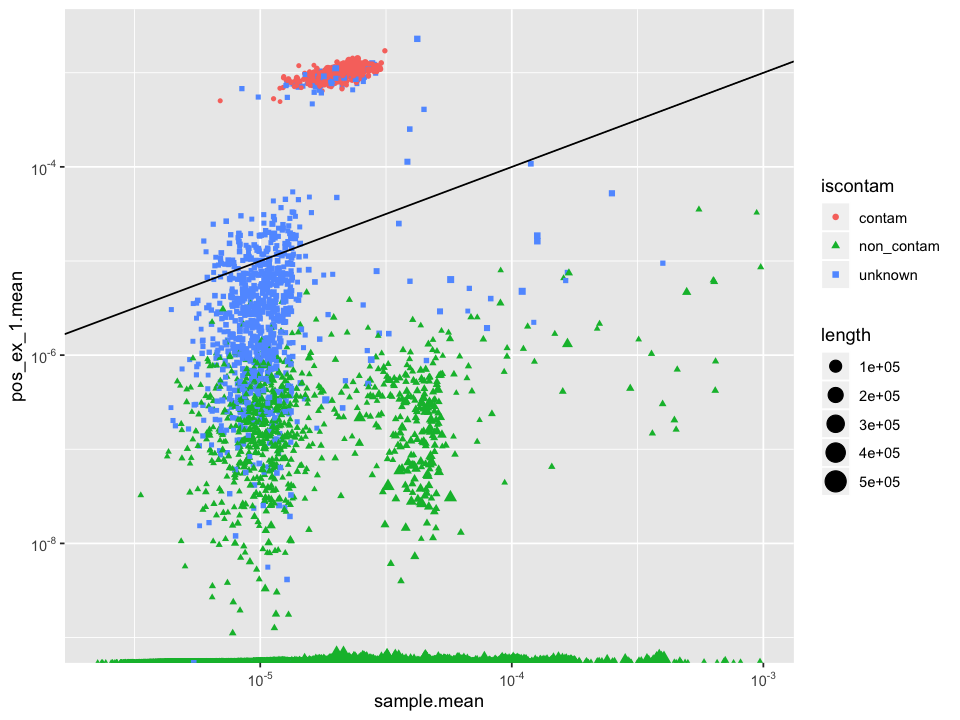

In [255]:
options(repr.plot.width = 8, repr.plot.height = 6)

ggplot(df, aes(x=sample.mean, y=pos_ex_1.mean, color=iscontam, shape=iscontam, size=length))+
    geom_point()+
    geom_abline(intercept=0, slope=1)+
    scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))+
    scale_x_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))


Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

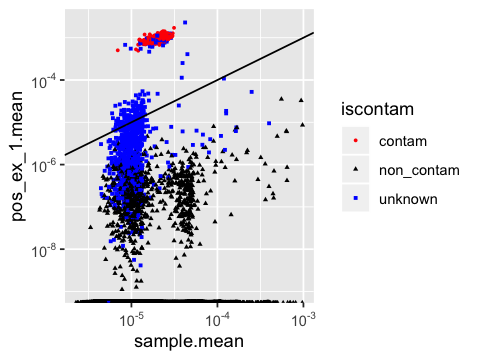

Warning message:
“Transformation introduced infinite values in continuous y-axis”

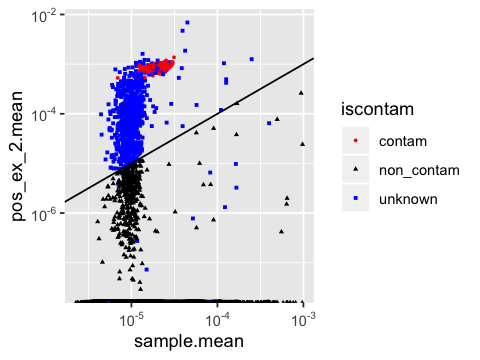

Warning message:
“Transformation introduced infinite values in continuous y-axis”

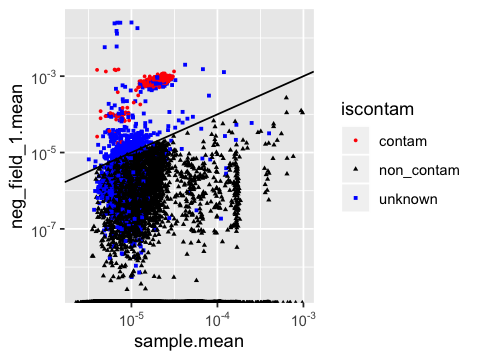

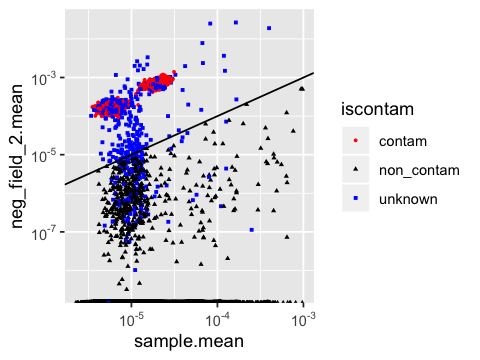

In [260]:
options(repr.plot.width = 4, repr.plot.height = 3)

ggplot(df, aes(x=sample.mean, y=pos_ex_1.mean, color=iscontam, shape=iscontam))+
    geom_point(size=.75)+
    geom_abline(intercept=0, slope=1)+
    scale_color_manual(values=c('red', 'black', 'blue'))+
    scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))+
    scale_x_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))

ggplot(df, aes(x=sample.mean, y=pos_ex_2.mean, color=iscontam, shape=iscontam))+
    geom_point(size=.75)+
    geom_abline(intercept=0, slope=1)+
    scale_color_manual(values=c('red', 'black', 'blue'))+
    scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))+
    scale_x_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))

ggplot(df, aes(x=sample.mean, y=neg_field_1.mean, color=iscontam, shape=iscontam))+
    geom_point(size=.75)+
    geom_abline(intercept=0, slope=1)+
    scale_color_manual(values=c('red', 'black', 'blue'))+
    scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))+
    scale_x_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))

ggplot(df, aes(x=sample.mean, y=neg_field_2.mean, color=iscontam, shape=iscontam))+
    geom_point(size=.75)+
    geom_abline(intercept=0, slope=1)+
    scale_color_manual(values=c('red', 'black', 'blue'))+
    scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))+
    scale_x_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

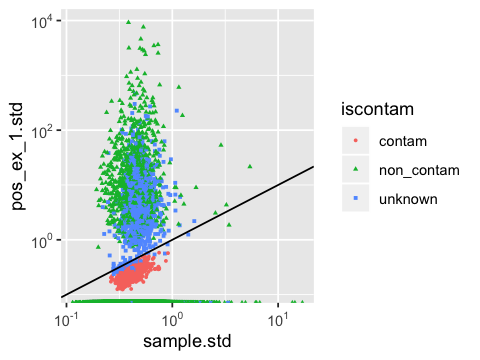

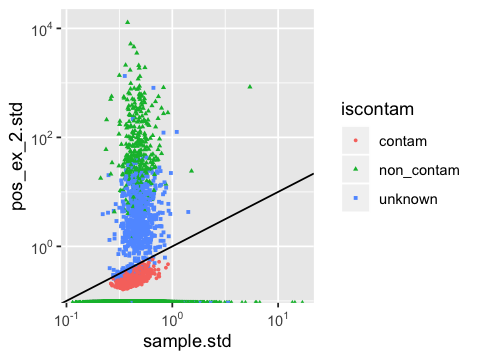

In [257]:
ggplot(df, aes(x=sample.std, y=pos_ex_1.std, color=iscontam, shape=iscontam))+
    geom_point(size=.75)+
    geom_abline(intercept=0, slope=1)+
    scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))+
    scale_x_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))

ggplot(df, aes(x=sample.std, y=pos_ex_2.std, color=iscontam, shape=iscontam))+
    geom_point(size=.75)+
    geom_abline(intercept=0, slope=1)+
    scale_y_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))+
    scale_x_continuous(trans="log10", labels=trans_format("log10", math_format(10^.x)))

In [ ]:
# this seems too simplistic...

In [228]:
# how much data is in each pot?
assem_len = sum(df$length)
round(sum(df[df$iscontam=='contam', 'length']) * 100 / assem_len, 2)
round(sum(df[df$iscontam=='non_contam', 'length']) * 100 / assem_len, 2)
round(sum(df[df$iscontam=='unknown', 'length']) * 100 / assem_len, 2)

[1] 2.42

[1] 96.28

[1] 1.3

In [231]:
assem_cov = sum(df$AWTP_2_RO2_bulk_5.mean)
round(sum(df[df$iscontam=='contam', 'AWTP_2_RO2_bulk_5.mean']) * 100, 2)
round(sum(df[df$iscontam=='non_contam', 'AWTP_2_RO2_bulk_5.mean']) * 100, 2)
round(sum(df[df$iscontam=='unknown', 'AWTP_2_RO2_bulk_5.mean']) * 100, 2)

[1] 2.04

[1] 96.17

[1] 1.79

In [ ]:
# for each control, check the rules, collect all contigs that are contams when compared to each control
# track how many times a contig appears as a contaminant (e.g. which samples)